# Prediksi kualitas logam Emas

## Konten<a id='back'></a>

* [Pendahuluan](#intro)
* [Tahap 1. Inisialisasi data](#inisial)
* [Tahap 2. Mempersiapkan data data](#prepare)
* [Tahap 3. Analisis Data](#analyze)
* [Tahap 4. Mempersiapkan Model](#machineprep)
* [Tahap 5. Membuat Model](#machine)
* [Tahap 6. Evaluasi Akhir](#evaluate)
* [Kesimpulan Umum](#conclusion)
    * [Temuan](#end)
    * [Rekomendasi](#recom)

## Pendahuluan<a id='intro'></a>

Data yang dibutuhkan tersimpan dalam tiga file:
- `gold_recovery_train.csv`
- `gold_recovery_test.csv`
- `gold_recovery_full.csv`

Data ini diindeks sesuai dengan tanggal dan waktu perolehannya (fitur date). Terkait waktu, parameter yang letaknya bersebelahan umumnya bersifat mirip. Sebagian parameter tidak tersedia karena pengukuran dan/atau penghitungannya dilakukan jauh setelahnya sehingga beberapa fitur yang ada di training set mungkin tidak ada di test set. Test set-nya pun juga tidak memuat target. Dataset sumber memuat training dan test set dengan semua fitur-fiturnya.

Sebagai catatan, data yang ada adalah data mentah yang baru saja diunduh dari gudang data. Sebelum membuat model, periksa ketepatan data tsb. 

Deskripsi Data

Proses teknologi
- Rougher feed — bahan mentah untuk proses flotasi
- Rougher additions (atau reagent additions) — reagen untuk flotasi: Xanthate, Sulphate, Depressant
- Xanthate — penggerak atau aktivator flotasi
- Sulphate — natrium sulfida, khusus untuk proses ini
- Depressant — natrium silikat
- Rougher process — flotasi
- Rougher tails — residu produk
- Float banks — unit flotasi
- Cleaner process — pemurnian
- Rougher Au — konsentrat emas yang lebih kasar
- Final Au — konsentrat emas akhir

Parameter dari setiap tahapan yang tersedia
- air amount — volume udara
- fluid levels
- feed size — ukuran partikel umpan
- feed rate

Penamaan fitur

Berikut merupakan cara untuk memberikan nama pada fitur-fitur yang ada:
[stage].[parameter_type].[parameter_name]
Contoh: rougher.input.feed_ag

Nilai yang memungkinkan untuk [stage]:
- rougher — flotasi
- primary_cleaner — pemurnian pertama
- secondary_cleaner — pemurnian kedua
- final — karakteristik akhir

Nilai yang memungkinkan untuk [parameter_type]:
- input — parameter bahan mentah
- output — parameter produk
- state — parameter yang menunjukkan karakteristik tahapan saat ini
- calculation — perhitungan karakteristik


Instruksi Proyek
1. Siapkan datanya
- 1.1. Buka file dan pelajari datanya.
File path:
* `/datasets/gold_recovery_train.csv`
* `/datasets/gold_recovery_test.csv`
* `/datasets/gold_recovery_full.csv`
- 1.2. Periksa apakah perolehan emas telah dihitung dengan benar. Dengan menggunakan training set, hitung perolehan untuk fitur rougher.output.recovery. Temukan MAE antara perhitungan dan nilai fitur. Tunjukkan apa yang ditemukan.
- 1.3. Analisis fitur-fitur yang tidak tersedia pada test set. Apa saja parameter-parameter ini? Tipe apakah parameter-parameter tersebut?
- 1.4. Lakukan pra-pemrosesan data.

2. Analisis datanya
- 2.1. Buat catatan terkait bagaimana konsentrasi logam (Au, Ag, Pb) berubah, tergantung pada tahap pemurniannya.
- 2.2. Bandingkan distribusi ukuran partikel feed dalam training set dan test set. Jika distribusinya bervariasi secara signifikan, evaluasi model akan salah.
- 2.3. Pertimbangkan total konsentrasi semua substansi di tahap yang berbeda: feed mentah, konsentrasi yang lebih kasar, dan konsentrasi akhir. Apakah terlihat adanya nilai abnormal dalam distribusi total? Jika ya, apakah perlu menghapus nilai-nilai tersebut dari kedua sampel? Jelaskan yang ditemukan dan singkirkan anomalinya.

3. Buat modelnya
- 3.1. Buat sebuah fungsi yang digunakan untuk menghitung nilai sMAPE akhir.
- 3.2. Lakukan pelatihan pada model yang berbeda-beda. Evaluasi model-model tersebut menggunakan cross-validation. Pilih model terbaik dan uji model tersebut menggunakan sampel tes atau test sample. Tunjukkan apa yang ditemukan.


## Inisialisasi Data<a id='inisial'></a>

memasukkan library-library yang dibutuhkan:

In [1]:
#masukkan library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression

# set tema seaborn
sns.set_theme(palette='bright')

## Mempersiapkan data<a id='prepare'></a>

In [2]:
# Menyiapkan data
# File Training Dataset
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')

#File Test dataset
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')

#file full dataset
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')

### Memeriksa `gold_train`

In [3]:
#memeriksa dataset
gold_train.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


In [4]:
#melihat informasi umum
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


dapat dilihat bahwa dataset memiliki `87` kolom, yang berisi data dengan `dtypes` `object` dan `float`, terdiri dari `16860` entry

In [5]:
# mengecek nilai yang hilang pada dataset
gold_train.isna().sum()

date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64

terlihat bahwa banyak sekali nilai hilang pada kolom

In [6]:
#fungsi persentase missing values
def missing_values_percentage(df):
    missing_percentage = df.isna().sum().sort_values(ascending=False) / len(df) * 100
    return missing_percentage

In [7]:
#persentase missing values pada dataset `gold_train`
train_miss = missing_values_percentage(gold_train)
train_miss.head(10)

rougher.output.recovery               15.260973
rougher.output.tail_ag                13.345196
rougher.output.tail_sol               13.339265
rougher.output.tail_au                13.339265
secondary_cleaner.output.tail_sol     11.779359
rougher.input.floatbank11_xanthate    11.293001
final.output.recovery                  9.021352
primary_cleaner.input.sulfate          7.752076
primary_cleaner.input.depressant       7.485172
rougher.calculation.au_pb_ratio        7.366548
dtype: float64

terlihat bahwa persentase nilai hilang mencapat `15%` yang mana ini cukup besar, sehingga harus ditanggulangi.

In [8]:
#fungsi untuk mengisi nilai hilang dengan median
def impute_missing_values_with_median(df):
    # Memisahkan kolom numerik dan non-numerik
    numeric_cols = df.select_dtypes(include=['number']).columns
    non_numeric_cols = df.select_dtypes(exclude=['number']).columns
    
    # Mengisi nilai yang hilang pada kolom numerik dengan nilai median
    imputer = SimpleImputer(strategy='median')
    df_numeric_imputed = pd.DataFrame(imputer.fit_transform(df[numeric_cols]), columns=numeric_cols, index=df.index)
    
    # Menggabungkan kembali kolom numerik dan non-numerik
    df_non_numeric = df[non_numeric_cols]
    df_imputed = pd.concat([df_numeric_imputed, df_non_numeric], axis=1)
    
    return df_imputed

In [9]:
#mengisi nilai hilang `gold_train`
train_imputed = impute_missing_values_with_median(gold_train)
train_imputed.isna().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
date                                          0
Length: 87, dtype: int64

dataset sudah terisi dengan baik menggunakan `median`

In [10]:
# mengecek duplikasi pada dataset
train_imputed.duplicated().sum()

0

tidak ada data yang terduplikasi

**Kesimpulan:** dataset terdiri dari`87` kolom, yang berisi data dengan `dtypes` `object` dan `float`, terdiri dari `16860` entry. terdapat banyak nilai hilang, yang kemudian diisi dengan `median`. tidak terdapat duplikasi data

In [11]:
#informasi umum tambahan
train_imputed.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,...,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000,16860.000000
mean,4.717558,9.117624,8.306743,39.488406,67.252087,8.758862,2.361340,9.310107,2.687879,129.658344,...,19.108646,-494.202107,14.779069,-476.726913,15.780592,-500.227898,12.370766,-498.961125,18.426799,-521.692466
std,2.092259,3.382819,3.783731,13.891712,11.408836,3.627098,1.209000,4.245353,1.270276,43.596476,...,6.857213,84.519894,5.982770,89.150570,6.817469,76.789234,6.204956,81.941333,6.937073,76.991432
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.021781,-0.423260,-799.741097,0.427084,-800.258209,0.024270,-810.473526
25%,3.975619,8.833034,6.976987,42.069327,63.262484,7.615686,1.650326,7.893909,2.176240,105.698879,...,14.514396,-500.827972,10.884523,-500.264455,10.980219,-500.526793,8.932437,-500.146651,13.982492,-501.057632
50%,4.869346,10.065316,8.557228,44.498874,67.644601,9.220393,2.453690,10.021968,2.781132,131.783108,...,19.986958,-499.778379,14.943933,-499.593286,15.998340,-499.784231,11.092839,-499.933330,18.034960,-500.109898
75%,5.816487,11.049568,10.238034,45.969495,72.257216,10.964690,3.183674,11.632896,3.413770,156.728392,...,24.982903,-495.052562,20.021099,-400.143224,19.997150,-496.677756,15.967104,-498.674800,24.984526,-499.568563
max,16.001945,17.031899,18.124851,53.611374,100.000000,19.552149,6.086532,22.317730,9.789625,251.999948,...,60.000000,-127.692333,28.003828,-71.472472,63.116298,-275.073125,39.846228,-120.190931,54.876806,-39.784927


In [12]:
#informasi umum dataset baru
train_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         16860 non-null  float64
 1   final.output.concentrate_pb                         16860 non-null  float64
 2   final.output.concentrate_sol                        16860 non-null  float64
 3   final.output.concentrate_au                         16860 non-null  float64
 4   final.output.recovery                               16860 non-null  float64
 5   final.output.tail_ag                                16860 non-null  float64
 6   final.output.tail_pb                                16860 non-null  float64
 7   final.output.tail_sol                               16860 non-null  float64
 8   final.output.tail_au                                16860 non-null  float64


### Memeriksa `gold_test`

In [13]:
#memeriksa dataset
gold_test.head(10)

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333
5,2016-09-01 05:59:59,168.485085,8.817007,7.420000,0.791191,1402.826803,-499.299521,1401.511119,-499.205357,1404.088107,...,12.029797,-499.814895,8.036586,-500.371492,8.041446,-510.037054,4.983949,-499.990990,24.978973,-500.475640
6,2016-09-01 06:59:59,144.133440,7.924610,7.420000,0.788838,1398.252401,-499.748672,1393.255503,-499.195380,1396.738566,...,12.026296,-499.473127,8.027984,-500.983079,7.907340,-507.964971,5.010224,-500.043697,25.040709,-499.501984
7,2016-09-01 07:59:59,133.513396,8.055252,6.988000,0.801871,1401.669677,-501.777839,1400.754446,-502.514024,1400.465244,...,12.040911,-501.293852,8.020490,-499.185229,8.116897,-511.927561,5.036498,-500.149615,25.032580,-503.970657
8,2016-09-01 08:59:59,133.735356,7.999618,6.935000,0.789329,1402.358981,-499.981597,1400.985954,-496.802968,1401.168584,...,11.998184,-499.481608,8.012610,-500.896783,7.974422,-521.199104,5.061599,-499.791519,25.005063,-497.613716
9,2016-09-01 09:59:59,126.961069,8.017856,7.030000,0.805298,1400.816120,-499.014158,1399.975401,-499.570552,1401.871924,...,12.040725,-499.987743,7.989503,-499.750625,7.989710,-509.946737,5.068811,-499.293900,24.992741,-499.272255


In [14]:
#melihat informasi umum
gold_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-null   object 
 1   primary_cleaner.input.sulfate               5554 non-null   float64
 2   primary_cleaner.input.depressant            5572 non-null   float64
 3   primary_cleaner.input.feed_size             5856 non-null   float64
 4   primary_cleaner.input.xanthate              5690 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5840 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5840 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5840 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5840 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5840 non-null   float64
 10  primary_clea

<div class="alert alert-success">
<b>Chamdani's comment v.1</b> <a class="tocSkip"></a>

Hebat, Kerja bagus!

</div>

dapat dilihat bahwa dataset memiliki `52` kolom, yang berisi data dengan `dtypes` `object` dan `float`, terdiri dari `5856` entry

In [15]:
# mengecek nilai yang hilang pada dataset
gold_test.isna().sum()

date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au                          16
rougher.input.floatbank10_sulfate             257


terlihat bahwa data memiliki cukup banyak nilai hilang

In [16]:
#persentase missing values pada dataset `gold_test`
test_miss = missing_values_percentage(gold_test)
test_miss.head(10)

rougher.input.floatbank11_xanthate          6.028005
primary_cleaner.input.sulfate               5.157104
primary_cleaner.input.depressant            4.849727
rougher.input.floatbank10_sulfate           4.388661
primary_cleaner.input.xanthate              2.834699
rougher.input.floatbank10_xanthate          2.100410
rougher.input.feed_sol                      1.144126
rougher.input.floatbank11_sulfate           0.939208
rougher.input.feed_rate                     0.683060
secondary_cleaner.state.floatbank3_a_air    0.580601
dtype: float64

persentase nilai hilang mencapat `6%` dari total keseluruhan data, dan diputuskan untuk mengisi nilai hilang tersebut

In [17]:
#mengisi nilai hilang `gold_test`
test_imputed = impute_missing_values_with_median(gold_test)
test_imputed.isna().sum()

primary_cleaner.input.sulfate                 0
primary_cleaner.input.depressant              0
primary_cleaner.input.feed_size               0
primary_cleaner.input.xanthate                0
primary_cleaner.state.floatbank8_a_air        0
primary_cleaner.state.floatbank8_a_level      0
primary_cleaner.state.floatbank8_b_air        0
primary_cleaner.state.floatbank8_b_level      0
primary_cleaner.state.floatbank8_c_air        0
primary_cleaner.state.floatbank8_c_level      0
primary_cleaner.state.floatbank8_d_air        0
primary_cleaner.state.floatbank8_d_level      0
rougher.input.feed_ag                         0
rougher.input.feed_pb                         0
rougher.input.feed_rate                       0
rougher.input.feed_size                       0
rougher.input.feed_sol                        0
rougher.input.feed_au                         0
rougher.input.floatbank10_sulfate             0
rougher.input.floatbank10_xanthate            0
rougher.input.floatbank11_sulfate       

dataset sudah tidak memiliki nilai hilang

In [18]:
# mengecek duplikasi pada dataset
test_imputed.duplicated().sum()

0

dataset tidak memiliki data yang terduplikasi

**Kesimpulan:** dataset memiliki `52` kolom, yang berisi data dengan `dtypes` `object` dan `float`, terdiri dari `5856` entry, terdapat beberapa nilai hilang dan diisi menggunakan `median`, tidak terdapat duplikasi data

In [19]:
#informasi umum tambahan
test_imputed.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,...,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000,5856.000000
mean,170.803455,8.460583,7.264651,1.317507,1482.188792,-509.033040,1487.089980,-511.712051,1468.707417,-509.714814,...,15.639763,-516.222069,13.150638,-476.402583,12.308295,-512.174901,9.472379,-505.004121,16.676887,-512.318058
std,48.328072,3.272262,0.611526,0.683732,310.051896,61.257214,312.815201,67.050047,309.583465,62.588214,...,4.655008,62.676582,4.299235,105.412129,3.757704,58.787594,3.308049,68.692347,5.397238,69.827196
min,0.000103,0.000031,5.650000,0.000003,0.000000,-799.773788,0.000000,-800.029078,0.000000,-799.995127,...,0.000000,-799.798523,0.000000,-800.836914,-0.223393,-799.661076,0.528083,-800.220337,-0.079426,-809.859706
25%,145.570738,6.468654,6.885625,0.893229,1497.244023,-500.453676,1497.194415,-500.933376,1438.144447,-501.293883,...,12.061651,-501.046834,11.888077,-500.416905,10.133598,-500.875187,7.991788,-500.222374,13.016156,-500.828740
50%,176.103893,8.023252,7.259333,1.183362,1554.659783,-499.997402,1553.268084,-500.066588,1546.160672,-500.079537,...,17.001867,-500.160145,14.952102,-499.644328,12.062877,-500.047621,9.980774,-500.001338,16.007242,-500.041085
75%,205.165772,10.002083,7.650000,1.705499,1601.663393,-499.576625,1601.742913,-499.325756,1600.779636,-499.013265,...,18.030272,-499.444757,15.938679,-401.623704,15.017197,-499.299273,11.992018,-499.723275,21.008868,-499.401579
max,274.409626,40.024582,15.500000,5.433169,2212.432090,-57.195404,1975.147923,-142.527229,1715.053773,-150.937035,...,30.051797,-401.565212,31.269706,-6.506986,25.258848,-244.483566,14.090194,-126.463446,26.705889,-29.093593


In [20]:
#informasi umum dataset baru
test_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   primary_cleaner.input.sulfate               5856 non-null   float64
 1   primary_cleaner.input.depressant            5856 non-null   float64
 2   primary_cleaner.input.feed_size             5856 non-null   float64
 3   primary_cleaner.input.xanthate              5856 non-null   float64
 4   primary_cleaner.state.floatbank8_a_air      5856 non-null   float64
 5   primary_cleaner.state.floatbank8_a_level    5856 non-null   float64
 6   primary_cleaner.state.floatbank8_b_air      5856 non-null   float64
 7   primary_cleaner.state.floatbank8_b_level    5856 non-null   float64
 8   primary_cleaner.state.floatbank8_c_air      5856 non-null   float64
 9   primary_cleaner.state.floatbank8_c_level    5856 non-null   float64
 10  primary_clea

### Memeriksa `gold_full`

In [21]:
#memeriksa dataset
gold_full.head(10)

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691
5,2016-01-15 05:00:00,6.482968,10.049416,5.480257,41.633678,69.465816,10.182708,0.664118,16.999638,1.918586,...,13.938497,-500.970168,11.883350,-500.395298,10.054147,-496.374715,7.965083,-499.364752,14.017067,-599.707915
6,2016-01-15 06:00:00,6.533849,10.058141,4.569100,41.995316,69.300835,10.304598,0.807342,16.723575,2.058913,...,14.046819,-500.971133,12.091543,-500.501426,10.003247,-497.083180,8.010890,-500.002423,14.029649,-600.905470
7,2016-01-15 07:00:00,6.130823,9.935481,4.389813,42.452727,70.230976,10.443288,0.949346,16.689959,2.143437,...,13.974691,-501.819696,12.101324,-500.583446,9.873169,-499.171928,7.993381,-499.794518,13.984498,-600.411070
8,2016-01-15 08:00:00,5.834140,10.071156,4.876389,43.404078,69.688595,10.420140,1.065453,17.201948,2.209881,...,13.964030,-504.252450,12.060738,-501.174549,10.033838,-501.178133,7.881604,-499.729434,13.967135,-599.061188
9,2016-01-15 09:00:00,5.687063,9.980404,5.282514,43.235220,70.279619,10.487013,1.159805,17.483979,2.209593,...,13.989632,-503.195299,12.052233,-500.928547,9.962574,-502.986357,7.979219,-500.146835,13.981614,-598.070855


In [22]:
#melihat informasi umum
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                22716 non-null  object 
 1   final.output.concentrate_ag                         22627 non-null  float64
 2   final.output.concentrate_pb                         22629 non-null  float64
 3   final.output.concentrate_sol                        22331 non-null  float64
 4   final.output.concentrate_au                         22630 non-null  float64
 5   final.output.recovery                               20753 non-null  float64
 6   final.output.tail_ag                                22633 non-null  float64
 7   final.output.tail_pb                                22516 non-null  float64
 8   final.output.tail_sol                               22445 non-null  float64


dapat dilihat bahwa dataset memiliki `87` kolom, yang berisi data dengan `dtypes` `object` dan `float`, terdiri dari `22716` entry

In [23]:
# mengecek nilai yang hilang pada dataset
gold_full.isna().sum()

date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64

terlihat bahwa cukup banyak nilai yang hilang dari dataset sehingga perlu diisi dengan nilai `median`

In [24]:
#persentase missing values pada dataset `gold_full`
full_miss = missing_values_percentage(gold_full)
full_miss.head(10)

rougher.output.recovery               13.730410
rougher.output.tail_ag                12.048776
rougher.output.tail_au                12.044374
rougher.output.tail_sol               12.044374
rougher.input.floatbank11_xanthate     9.935728
secondary_cleaner.output.tail_sol      9.750836
final.output.recovery                  8.641486
rougher.calculation.au_pb_ratio        7.162353
primary_cleaner.input.sulfate          7.083113
primary_cleaner.input.depressant       6.805776
dtype: float64

In [25]:
#mengisi nilai hilang `gold_full`
full_imputed = impute_missing_values_with_median(gold_full)
full_imputed.isna().sum()

final.output.concentrate_ag                   0
final.output.concentrate_pb                   0
final.output.concentrate_sol                  0
final.output.concentrate_au                   0
final.output.recovery                         0
                                             ..
secondary_cleaner.state.floatbank5_b_air      0
secondary_cleaner.state.floatbank5_b_level    0
secondary_cleaner.state.floatbank6_a_air      0
secondary_cleaner.state.floatbank6_a_level    0
date                                          0
Length: 87, dtype: int64

nilai hilang sudah diisi dengan nilai `median`

In [26]:
# mengecek duplikasi pada dataset
full_imputed.duplicated().sum()

0

tidak ada yang terduplikasi

**Kesimpulan:** dataset memiliki `87` kolom, yang berisi data dengan `dtypes` `object` dan `float`, terdiri dari `22716` entry, terdapat beberapa nilai hilang dan diisi menggunakan `median`, tidak terdapat duplikasi data

In [27]:
#informasi umum tambahan
full_imputed.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,...,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000,22716.000000
mean,4.782234,9.098446,8.644867,40.018785,67.523081,8.925739,2.489703,9.531856,2.827767,140.352245,...,18.203862,-499.879193,14.359285,-476.643358,14.883169,-503.307912,11.623910,-500.518995,17.976953,-519.275804
std,2.026175,3.225001,3.752981,13.375727,11.105494,3.511647,1.184259,4.056020,1.260591,48.119305,...,6.539745,80.045699,5.642476,93.611000,6.358627,72.763644,5.744791,78.782312,6.618798,75.320071
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,...,0.000000,-799.920713,0.000000,-800.836914,-0.423260,-799.741097,0.427084,-800.258209,-0.079426,-810.473526
25%,4.021406,8.757079,7.146172,42.396820,63.905025,7.689219,1.813414,8.174090,2.306045,112.909004,...,14.459159,-500.887600,10.904530,-500.304586,10.942785,-500.622002,8.040286,-500.166619,13.974249,-500.973754
50%,4.953729,9.914519,8.908792,44.653436,68.322258,9.484369,2.653001,10.212998,2.913794,141.330501,...,18.007326,-499.917108,14.947646,-499.612292,14.859117,-499.865158,10.989756,-499.951980,18.004215,-500.095463
75%,5.857985,10.925233,10.659979,46.106662,72.494845,11.080615,3.279744,11.839647,3.552452,170.971796,...,22.996115,-498.383388,17.962227,-400.230007,18.014080,-498.508678,13.999903,-499.500512,23.007579,-499.531052
max,16.001945,17.031899,19.615720,53.611374,100.000000,19.552149,6.086532,22.861749,9.789625,274.409626,...,60.000000,-127.692333,31.269706,-6.506986,63.116298,-244.483566,39.846228,-120.190931,54.876806,-29.093593


In [28]:
#informasi umum dataset baru
full_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   final.output.concentrate_ag                         22716 non-null  float64
 1   final.output.concentrate_pb                         22716 non-null  float64
 2   final.output.concentrate_sol                        22716 non-null  float64
 3   final.output.concentrate_au                         22716 non-null  float64
 4   final.output.recovery                               22716 non-null  float64
 5   final.output.tail_ag                                22716 non-null  float64
 6   final.output.tail_pb                                22716 non-null  float64
 7   final.output.tail_sol                               22716 non-null  float64
 8   final.output.tail_au                                22716 non-null  float64


### Mengganti tipe data kolom `date`

In [29]:
# Mengonversi kolom date menjadi datetime
train_imputed['date'] = pd.to_datetime(train_imputed['date'])
test_imputed['date'] = pd.to_datetime(test_imputed['date'])
full_imputed['date'] = pd.to_datetime(full_imputed['date'])


dataset baru yang sudah bersih berganti nama menjadi `train_imputed`, `test_imputed` dan `full_imputed`.

### Membandingkan perbedaan `gold_train` dan `gold_test`

In [30]:
# parameter yang tidak ada pada dataset test
difference = list(set(gold_train.columns)-set(gold_test.columns))
sorted(difference)

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

terlihat bahwa banyak kolom yang ternyata tidak ada di `gold_test`. secara umum terdiri dari `4 parameter` output yang berbeda.

### Melengkapi dataset `gold_test`

seperti yang diketahui sebelumnya, dataset `gold_test` kekurangan beberapa kolom parameter, untuk itu perlu ditambahkan terlebih dahulu menggunakan dataset `gold_full`

In [31]:
# mendupliasi dataset full dan membuang nama kolom yang sama dengan dataset test
temp = full_imputed.copy().drop(test_imputed.columns,axis=1)

# menggabungkan dataset temp dengan dataset test
test_imputed = pd.merge(test_imputed,temp,left_index=True,right_index=True,how='left')

# mengatur nama kolom agar sesuai dengan urutan nama kolom dataset train
test_imputed = test_imputed.loc[:,train_imputed.columns]
test_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   final.output.concentrate_ag                         5856 non-null   float64       
 1   final.output.concentrate_pb                         5856 non-null   float64       
 2   final.output.concentrate_sol                        5856 non-null   float64       
 3   final.output.concentrate_au                         5856 non-null   float64       
 4   final.output.recovery                               5856 non-null   float64       
 5   final.output.tail_ag                                5856 non-null   float64       
 6   final.output.tail_pb                                5856 non-null   float64       
 7   final.output.tail_sol                               5856 non-null   float64       
 8   final.ou

terlihat bahwa urutan kolom `date` berpindah, sebelum melanjutkan mari kita pindahkan kolom tersebut ke posisi semula.

In [32]:
# Pindahkan kolom 'date' ke posisi awal
cols = test_imputed.columns.tolist()
cols.insert(0, cols.pop(cols.index('date')))
test_imputed = test_imputed[cols]

# Tampilkan informasi dari dataset yang telah diubah
test_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                5856 non-null   datetime64[ns]
 1   final.output.concentrate_ag                         5856 non-null   float64       
 2   final.output.concentrate_pb                         5856 non-null   float64       
 3   final.output.concentrate_sol                        5856 non-null   float64       
 4   final.output.concentrate_au                         5856 non-null   float64       
 5   final.output.recovery                               5856 non-null   float64       
 6   final.output.tail_ag                                5856 non-null   float64       
 7   final.output.tail_pb                                5856 non-null   float64       
 8   final.ou

sekarang dataset `gold_test` sudah bisa digunakan.

## Analisis Data

Disini kita akan mengkomparasi parameter perolehan emas `recovery` yang ada pada dataset dengan perhitungan `manual calculation` menggunakan rumus perolehan emas seperti berikut.

In [33]:
# menghitung perolehan emas dari bijih emas
# formula = Cx(F-T)/Fx(C-T)*100
C = train_imputed['rougher.output.concentrate_au']
F = train_imputed['rougher.input.feed_au']
T = train_imputed['rougher.output.tail_au']

# membuat perhitungan perolehan emas manual
gain_calc = (C*(F-T))/(F*(C-T))*100

# mengecek distribusi gain_calc
gain_calc.describe()

count    1.574500e+04
mean              NaN
std               NaN
min              -inf
25%      7.984719e+01
50%      8.549758e+01
75%      9.073762e+01
max               inf
dtype: float64

Hasil menunjukan adanya nilai `NaN`, `-inf` dan `inf`. sebelum menghilangkannya, mari kita gabungkan data recovery dan calculation terlebih dahulu.

In [34]:
# menggabungkan perolehan recovery dengan perolehan kalkulasi
merge = pd.concat([train_imputed['rougher.output.recovery'],gain_calc],axis=1)
merge.columns = ['recovery','calculation']

In [35]:
# mengganti nilai inf dan -inf dengan NaN
merge['calculation'] = merge['calculation'].replace([np.inf,-np.inf], np.nan)

# menghapus semua missing values
merge.dropna(inplace=True)

# mengecek kembali distribusi kolom manual.count
merge.describe()

,recovery,calculation
count,15701.000000,15701.000000
mean,82.650128,32.541230
std,14.423894,3197.085079
min,0.000000,-366924.161290
25%,80.435925,79.909374
50%,85.235997,85.516148
75%,89.703946,90.752079
max,100.000000,13802.071756


sekarang data sudah tidak memiliki nilai `Nan`

In [36]:
# menghitung skor MAE antara hasil manual dengan hasil recovery
MAE_score = mean_absolute_error(merge['recovery'],merge['calculation'])
print('MAE Score -->', MAE_score)

MAE Score --> 56.831082843744696


nilai `MAE` ini cukup tinggi sehingga perlu diteliti lebih lanjut, nilai `MAE` yang tinggi menunjukkan kurangnya akurasi data antara `recovery` dan `calculation`

### Perubahan Konsentrat Logam `Au` (emas)

In [37]:
# Mengatur kolom date sebagai index
train_imputed.set_index('date', inplace=True)
test_imputed.set_index('date', inplace=True)
full_imputed.set_index('date', inplace=True)

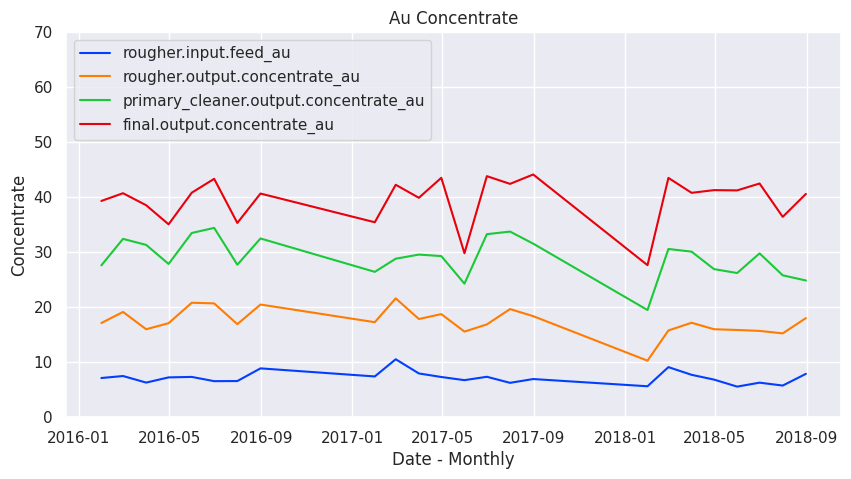

In [38]:
# Mengelompokan dataset menjadi bulanan
train_monthly = train_imputed.resample('M').mean()

# Menggambar grafik perubahan konsentrasi Logam Au berdasarkan stage
plt.figure(figsize=(10,5))
sns.lineplot(data=train_monthly, y='rougher.input.feed_au', x=train_monthly.index, label='rougher.input.feed_au')
sns.lineplot(data=train_monthly, y='rougher.output.concentrate_au', x=train_monthly.index, label='rougher.output.concentrate_au')
sns.lineplot(data=train_monthly, y='primary_cleaner.output.concentrate_au', x=train_monthly.index, label='primary_cleaner.output.concentrate_au')
sns.lineplot(data=train_monthly, y='final.output.concentrate_au', x=train_monthly.index, label='final.output.concentrate_au')

# Menampilkan grafik
plt.legend(loc='upper left')
plt.ylim(0, 70)
plt.xlabel('Date - Monthly')
plt.ylabel('Concentrate')
plt.title('Au Concentrate')
plt.show()


terlihat bahwa keempat grafik memiliki alur kurva yang hampir sama dengan peningkatan setiap proses yang hampir serupa pula, ini menandakan tingkatannya selalu stabil setiap bulannya. Konsentrasi paling tinggi dihasilkan pada proses `final_output`.

### Perubahaan konsentrat logam `Ag` (perak)

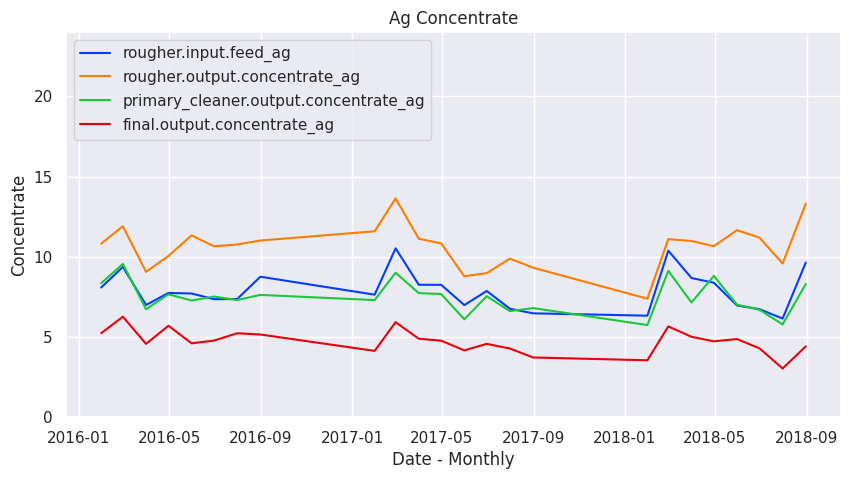

In [39]:
# menggambar grafik perubahan konsentrasi Logam Ag berdasarkan stage
plt.figure(figsize=(10,5))
sns.lineplot(data=train_monthly,y='rougher.input.feed_ag',x=train_monthly.index,label='rougher.input.feed_ag')
sns.lineplot(data=train_monthly,y='rougher.output.concentrate_ag',x=train_monthly.index,label='rougher.output.concentrate_ag')
sns.lineplot(data=train_monthly,y='primary_cleaner.output.concentrate_ag',x=train_monthly.index,label='primary_cleaner.output.concentrate_ag')
sns.lineplot(data=train_monthly,y='final.output.concentrate_ag',x=train_monthly.index,label='final.output.concentrate_ag')

# menampilkan grafik
plt.legend(loc='upper left')
plt.ylim(0,24)
plt.xlabel('Date - Monthly')
plt.ylabel('Concentrate')
plt.title('Ag Concentrate')
plt.show()

terlihat bahwa keempat grafik memiliki alur kurva yang hampir sama dengan peningkatan akan tetapi proses `rougher_input` dan `primer_cleaner_output` memiliki konsentrasi yang hampir serupa. ini menandakan kedua proses tersebut tidak terlalu signifikan meningkatkan konsentrasi logam. Konsentrasi paling tinggi didapatkan justru pada proses `rougher_input`. dan proses `final_output` memiliki nilai konsentrasi terendah.

### Perubahan konsentrat logam `Pb` (timbal)

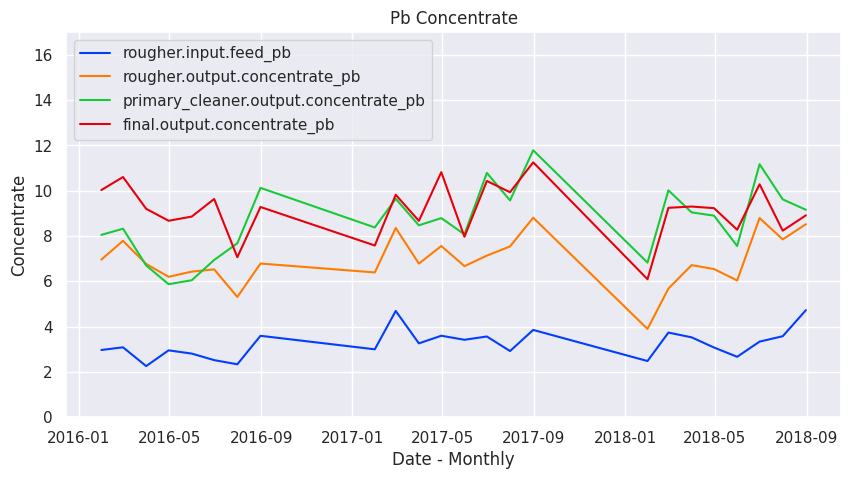

In [40]:
# menggambar grafik perubahan konsentrasi Logam Pb berdasarkan stage
plt.figure(figsize=(10,5))
sns.lineplot(data=train_monthly,y='rougher.input.feed_pb',x=train_monthly.index,label='rougher.input.feed_pb')
sns.lineplot(data=train_monthly,y='rougher.output.concentrate_pb',x=train_monthly.index,label='rougher.output.concentrate_pb')
sns.lineplot(data=train_monthly,y='primary_cleaner.output.concentrate_pb',x=train_monthly.index,label='primary_cleaner.output.concentrate_pb')
sns.lineplot(data=train_monthly,y='final.output.concentrate_pb',x=train_monthly.index,label='final.output.concentrate_pb')

# menampilkan grafik
plt.legend(loc='upper left')
plt.ylim(0,17)
plt.xlabel('Date - Monthly')
plt.ylabel('Concentrate')
plt.title('Pb Concentrate')
plt.show()

terlihat bahwa keempat grafik memiliki alur kurva yang hampir sama dengan peningkatan akan tetapi proses `primary_cleaner_output` memiliki konsentrasi yang hampir serupa dengan `final_output`. Konsentrasi paling tinggi didapatkan secara umum pada proses `final_output`.

**Kesimpulan:** konsentrasi logam tertinggi logam `Au` dan `Pb` adalah pada proses `final_output`, tetapi logam `Ag` justru memiliki konsentrasi tertinggi pada proses `rougher_input`.

### Distribusi ukuran partikel feed

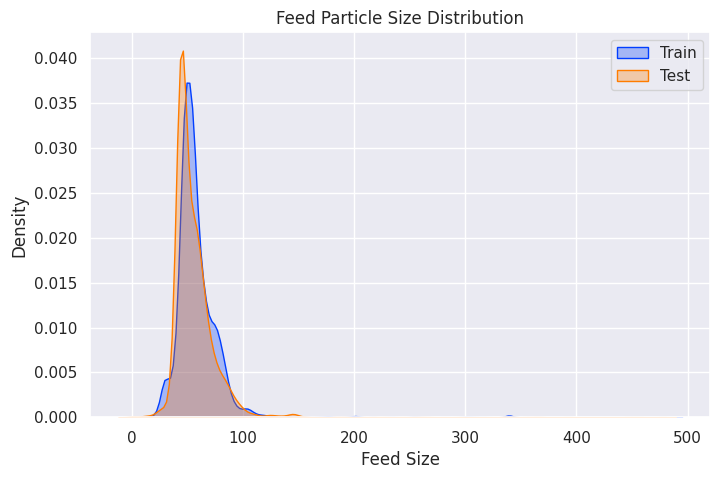

In [41]:
# membuat grafik plot distribusi partikel feed
plt.figure(figsize=(8,5))
sns.kdeplot(data=train_imputed['rougher.input.feed_size'],alpha=0.3,fill=True,label='Train')
sns.kdeplot(data=test_imputed['rougher.input.feed_size'],alpha=0.3,fill=True,label='Test')
plt.legend()
plt.xlabel('Feed Size')
plt.title('Feed Particle Size Distribution')
plt.show()

Dari grafik menunjukan distribusi variasi ukuran partikel umpan `(feed)` yang seragam yang berada diantara ukuran `30 hingga 110` sehingga bisa dijadikan acuan untuk model machine learning.

### Distribusi Konsentrasi partikel

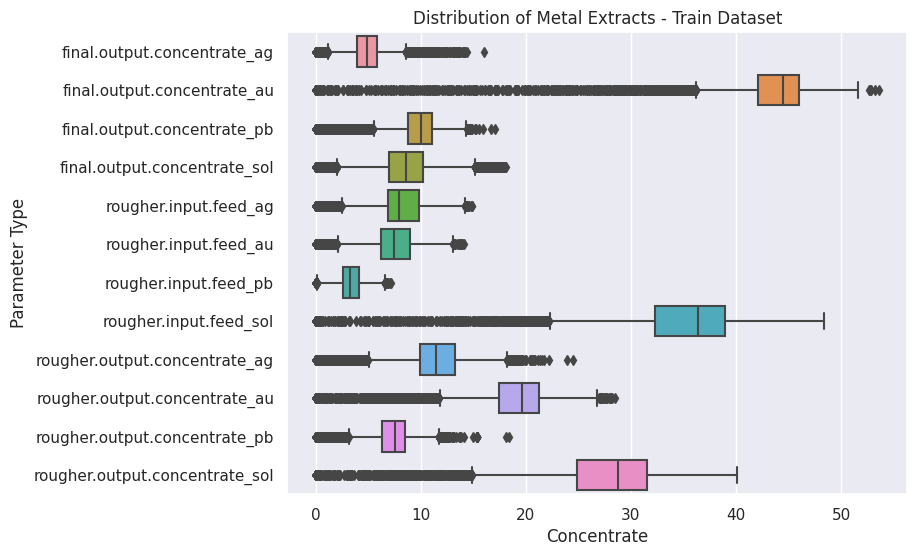

In [42]:
# nama kolom yang akan dicek
columns = [
    'final.output.concentrate_ag',
    'final.output.concentrate_au',
    'final.output.concentrate_pb',
    'final.output.concentrate_sol',
    'rougher.input.feed_ag',
    'rougher.input.feed_au',
    'rougher.input.feed_pb',
    'rougher.input.feed_sol',
    'rougher.output.concentrate_ag',
    'rougher.output.concentrate_au',
    'rougher.output.concentrate_pb',
    'rougher.output.concentrate_sol',
    ]

# membuat boxplot untuk masing-masing logam dan stagenya untuk dataset train
plt.figure(figsize=(8,6))
sns.boxplot(data=train_imputed[columns],orient='h')
plt.xlabel('Concentrate')
plt.ylabel('Parameter Type')
plt.title('Distribution of Metal Extracts - Train Dataset')
plt.show()

Bisa kita lihat pada grafik boxplot dataset train diatas terdapat 4 stage yang memiliki outliers terbanyak yaitu `final.output.concentrate_au`, `rougher.output.concentrate_au`, `rougher.input.feed_sol`, `rougher.output.concentrate_sol`.

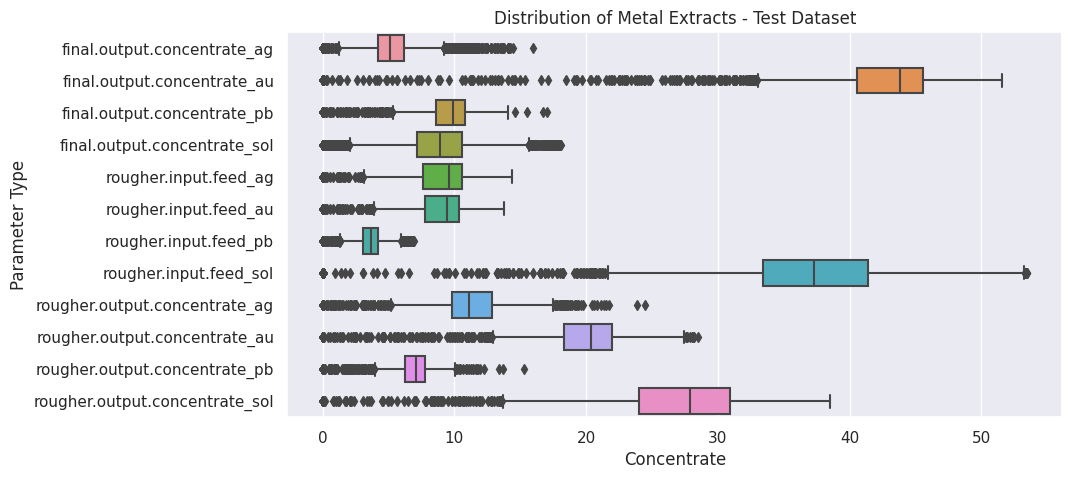

In [43]:
# membuat boxplot untuk masing-masing logam dan stagenya untuk dataset test
plt.figure(figsize=(10,5))
sns.boxplot(data=test_imputed[columns],orient='h')
plt.xlabel('Concentrate')
plt.ylabel('Parameter Type')
plt.title('Distribution of Metal Extracts - Test Dataset')
plt.show()

Bisa kita lihat pada grafik boxplot dataset test diatas terdapat 4 stage yang memiliki outliers terbanyak yaitu `final.output.concentrate_au`, `rougher.output.concentrate_au`, `rougher.input.feed_sol`, `rougher.output.concentrate_sol`.

### Memperbaiki kualitas `train_imputed`

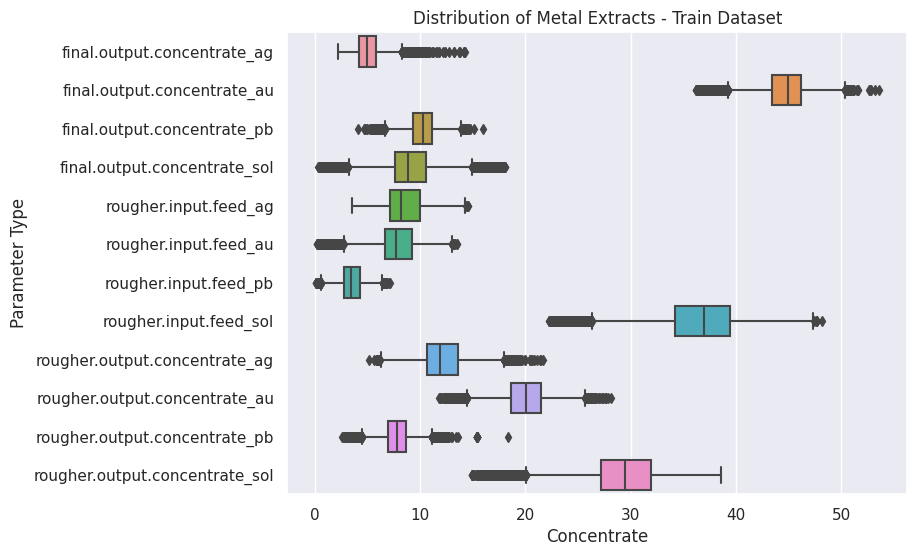

In [44]:
# menghitung Limit Lower dari kolom 'final.output.concentrate_au'
Q1_final = train_imputed['final.output.concentrate_au'].quantile(0.25)
Q3_final = train_imputed['final.output.concentrate_au'].quantile(0.75)
IQR_final = Q3_final - Q1_final
limit_lower_final = Q1_final - (1.5*IQR_final)

# menghitung Limit Lower dari kolom 'rougher.output.concentrate_au'
Q1_rough_au = train_imputed['rougher.output.concentrate_au'].quantile(0.25)
Q3_rough_au = train_imputed['rougher.output.concentrate_au'].quantile(0.75)
IQR_rough_au = Q3_rough_au - Q1_rough_au
limit_lower_rough_au = Q1_rough_au - (1.5*IQR_rough_au)

# menghitung Limit Lower dari kolom 'rougher.input.feed_sol'
Q1_rough_in_sol = train_imputed['rougher.input.feed_sol'].quantile(0.25)
Q3_rough_in_sol = train_imputed['rougher.input.feed_sol'].quantile(0.75)
IQR_rough_in_sol = Q3_rough_in_sol - Q1_rough_in_sol
limit_lower_rough_in_sol = Q1_rough_in_sol - (1.5*IQR_rough_in_sol)

# menghitung Limit Lower dari kolom 'rougher.output.concentrate_sol',
Q1_rough_out_sol = train_imputed['rougher.output.concentrate_sol'].quantile(0.25)
Q3_rough_out_sol = train_imputed['rougher.output.concentrate_sol'].quantile(0.75)
IQR_rough_out_sol = Q3_rough_out_sol - Q1_rough_out_sol
limit_lower_rough_out_sol = Q1_rough_out_sol - (1.5*IQR_rough_out_sol)

# membuang outlier pada dataset train
train_imputed = train_imputed[train_imputed['final.output.concentrate_au'] >= limit_lower_final]
train_imputed = train_imputed[train_imputed['rougher.output.concentrate_au'] >= limit_lower_rough_au]
train_imputed = train_imputed[train_imputed['rougher.input.feed_sol'] >= limit_lower_rough_in_sol]
train_imputed = train_imputed[train_imputed['rougher.output.concentrate_sol'] >= limit_lower_rough_out_sol]

# menampilkan boxplot untuk masing-masing logam dan stagenya untuk dataset train
plt.figure(figsize=(8,6))
sns.boxplot(data=train_imputed[columns],orient='h')
plt.xlabel('Concentrate')
plt.ylabel('Parameter Type')
plt.title('Distribution of Metal Extracts - Train Dataset')
plt.show()

`Outliers` sekarang dikurangi dari dataset `train`.

### Memperbaiki kualitas `test_imputed`

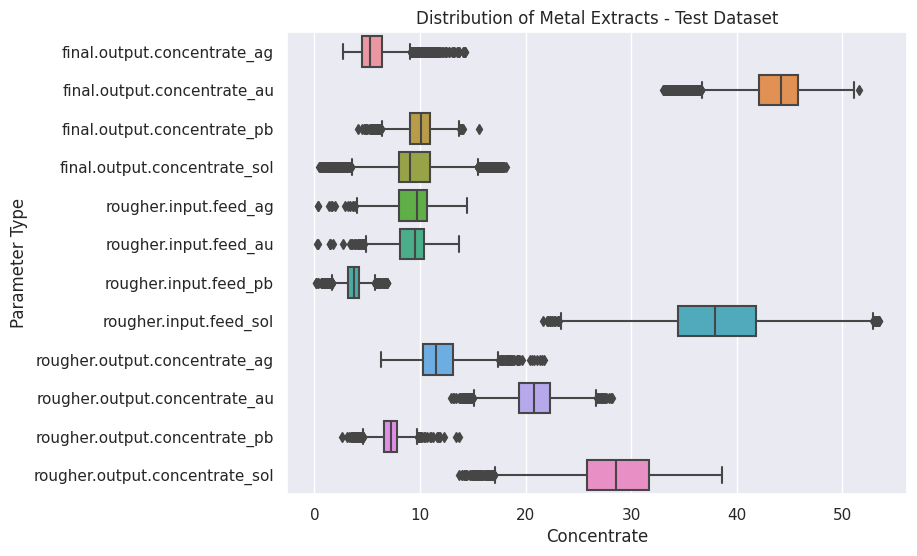

In [45]:
# menghitung Limit Lower dari kolom 'final.output.concentrate_au'
Q1_final = test_imputed['final.output.concentrate_au'].quantile(0.25)
Q3_final = test_imputed['final.output.concentrate_au'].quantile(0.75)
IQR_final = Q3_final - Q1_final
limit_lower_final = Q1_final - (1.5*IQR_final)

# menghitung Limit Lower dari kolom 'rougher.output.concentrate_au'
Q1_rough_au = test_imputed['rougher.output.concentrate_au'].quantile(0.25)
Q3_rough_au = test_imputed['rougher.output.concentrate_au'].quantile(0.75)
IQR_rough_au = Q3_rough_au - Q1_rough_au
limit_lower_rough_au = Q1_rough_au - (1.5*IQR_rough_au)

# menghitung Limit Lower dari kolom 'rougher.input.feed_sol'
Q1_rough_in_sol = test_imputed['rougher.input.feed_sol'].quantile(0.25)
Q3_rough_in_sol = test_imputed['rougher.input.feed_sol'].quantile(0.75)
IQR_rough_in_sol = Q3_rough_in_sol - Q1_rough_in_sol
limit_lower_rough_in_sol = Q1_rough_in_sol - (1.5*IQR_rough_in_sol)

# menghitung Limit Lower dari kolom 'rougher.output.concentrate_sol',
Q1_rough_out_sol = test_imputed['rougher.output.concentrate_sol'].quantile(0.25)
Q3_rough_out_sol = test_imputed['rougher.output.concentrate_sol'].quantile(0.75)
IQR_rough_out_sol = Q3_rough_out_sol - Q1_rough_out_sol
limit_lower_rough_out_sol = Q1_rough_out_sol - (1.5*IQR_rough_out_sol)

# membuang outlier pada dataset test
test_imputed = test_imputed[test_imputed['final.output.concentrate_au'] >= limit_lower_final]
test_imputed = test_imputed[test_imputed['rougher.output.concentrate_au'] >= limit_lower_rough_au]
test_imputed = test_imputed[test_imputed['rougher.input.feed_sol'] >= limit_lower_rough_in_sol]
test_imputed = test_imputed[test_imputed['rougher.output.concentrate_sol'] >= limit_lower_rough_out_sol]

# menampilkan boxplot untuk masing-masing logam dan stagenya untuk dataset test
plt.figure(figsize=(8,6))
sns.boxplot(data=test_imputed[columns],orient='h')
plt.xlabel('Concentrate')
plt.ylabel('Parameter Type')
plt.title('Distribution of Metal Extracts - Test Dataset')
plt.show()

`Outliers` sekarang dikurangi dari dataset `test`.

## Mempersiapkan Model

Sekarang akan dilakukan pembuatan model machine learning serta mengevaluasi model tersebut dengan menggunakan `teknik cross-validation` pada fungsi `SMAPE` (Symmetric Mean Absolute Percentage Error)

### Membuat Fungsi SMAPE (Symmetric Mean Absolute Percentage Error)

In [46]:
# fungsi untuk menghitung SMAPE (symmetric mean absolute percentage error)
def smape_score(y_true,y_pred):
    # membuat dataframe
    y_true = pd.DataFrame(y_true)
    y_pred = pd.DataFrame(y_pred)
    # mereset index
    y_true = y_true.reset_index(drop=True)
    y_pred = y_pred.reset_index(drop=True)
    # mendefinsikan variabel rough dan final
    y_true_rough = y_true.iloc[:,0]
    y_pred_rough = y_pred.iloc[:,0]
    y_true_final = y_true.iloc[:,1]
    y_pred_final = y_pred.iloc[:,1]

    # for loop untuk menghitung value rough
    temp_rough = []
    for i in range(len(y_pred)):
        # menghitung value tiap baris
        value = (abs(y_true_rough[i] - y_pred_rough[i]))/((abs(y_true_rough[i])+abs(y_pred_rough[i]))/2)
        # menambahkan hasil hitungan kedalam temp_rough
        temp_rough.append(value)
    # menghitung skor SMAPE
    score_rough = sum(temp_rough)/len(y_true)*100

    # for loop untuk menghitung value final
    temp_final = []
    for i in range(len(y_pred)):
        # menghitung value tiap baris
        value = (abs(y_true_final[i] - y_pred_final[i]))/((abs(y_true_final[i])+abs(y_pred_final[i]))/2)
        # menambahkan hasil hitungan kedalam temp_final
        temp_final.append(value)
    # menghitung skor SMAPE
    score_final = sum(temp_final)/len(y_true)*100

    # menghitung skor gabungan
    final_smape = score_rough*0.25 + score_final*0.75

    # mengembalikan skor SMAPE
    return final_smape

sebelum itu mari kita cek lagi kolom pada dataset `full_imputed`:

In [47]:
# mengecek nama parameter
full_imputed.columns

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_cleaner.state

nampaknya dataset kita berisi informasi yang hanya akan tersedia setelah proses produksi selesai yang seharusnya tidak ada pada dataset. untuk mengetahui adanya kebocoran dalam data akan digunakan perhitungan menggunakan matriks korelasi

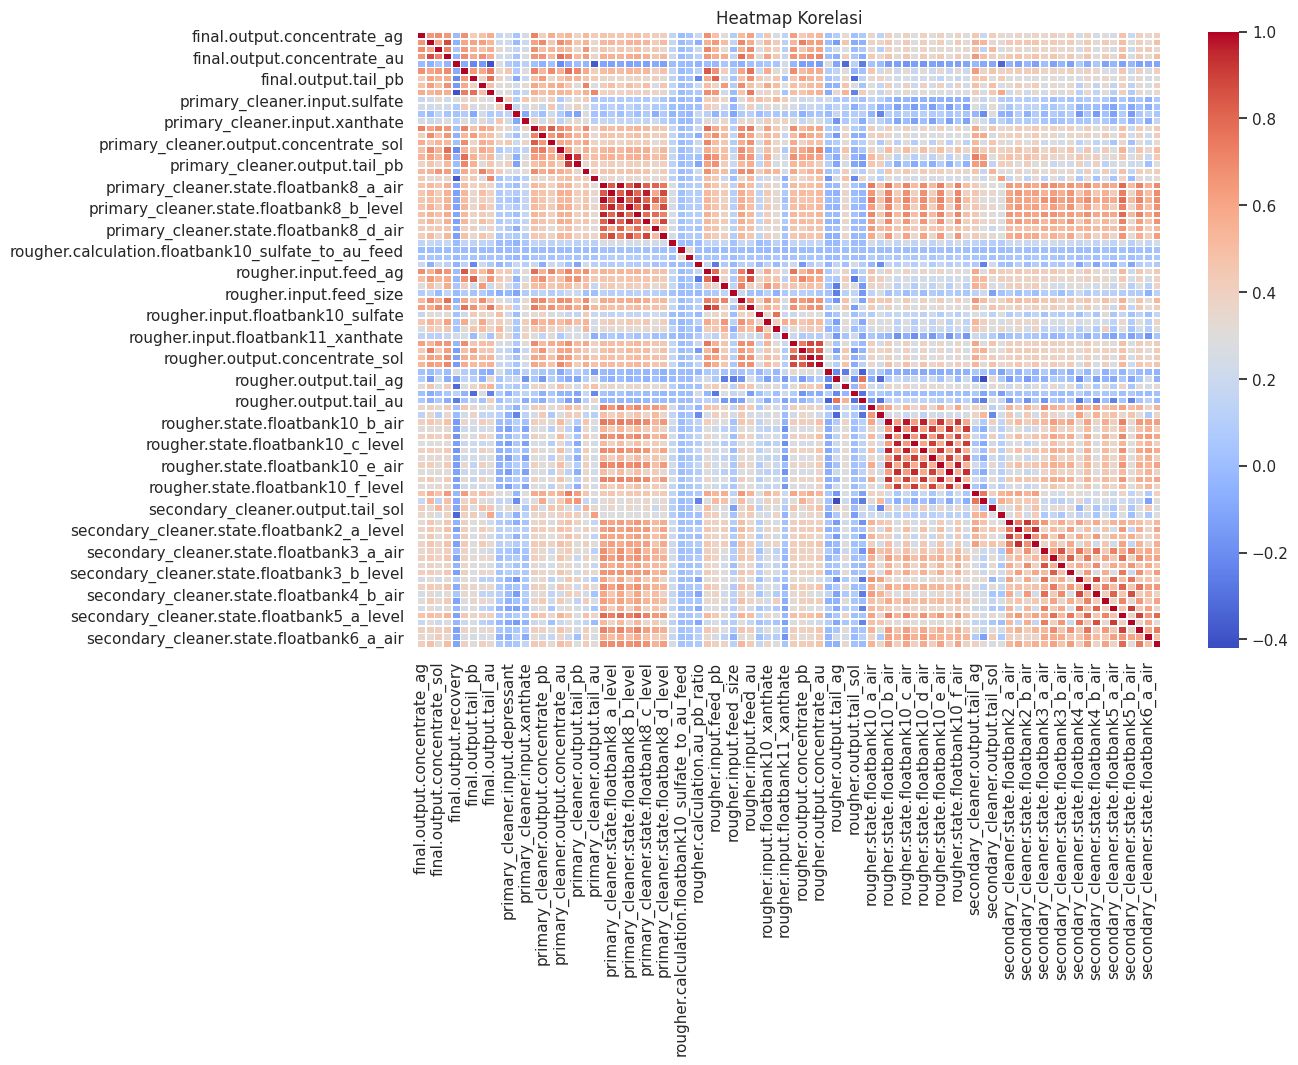

In [48]:
# Menghitung matriks korelasi
corr_matrix = full_imputed.corr()

# Visualisasi matriks korelasi menggunakan heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Heatmap Korelasi')
plt.show()

In [49]:
# Mengidentifikasi korelasi dengan target
target_columns = ['final.output.recovery', 'rougher.output.recovery']
for target in target_columns:
    corr_with_target = corr_matrix[target].sort_values(ascending=False)

# Menentukan threshold untuk korelasi tinggi
threshold = 0.8

# Menemukan fitur dengan korelasi tinggi dengan target
high_corr_features = []
for target in target_columns:
    high_corr = corr_matrix[target][corr_matrix[target] > threshold].index.tolist()
    high_corr_features.extend(high_corr)

# Menghapus duplikat
high_corr_features = list(set(high_corr_features))

# Menghapus kolom dengan korelasi tinggi dari dataset
cleaned_dataset = full_imputed.drop(columns=high_corr_features)

In [50]:
# Mengecek kolom setelah penghapusan
print("Kolom setelah penghapusan fitur dengan korelasi tinggi:")
print(cleaned_dataset.columns)

Kolom setelah penghapusan fitur dengan korelasi tinggi:
Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.tail_ag', 'final.output.tail_pb', 'final.output.tail_sol',
       'final.output.tail_au', 'primary_cleaner.input.sulfate',
       'primary_cleaner.input.depressant', 'primary_cleaner.input.feed_size',
       'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level'

In [51]:
# parameter yang tidak ada pada dataset test
difference2 = list(set(full_imputed.columns)-set(cleaned_dataset.columns))
sorted(difference2)

['final.output.recovery', 'rougher.output.recovery']

ternyata terdapat 2 kolom yang memiliki korelasi sangat tinggi sehingga diputuskan untuk menghapus 2 parameter ini sebelum melanjutkan.

In [52]:
# menghapus parameter yang diindikasi menyebabkan kebocoran data
delete = [
    'final.output.recovery',
    'rougher.output.recovery',
    ]

# menghilangkan parameter diatas pada dataset 
test_imputed.drop(delete,axis=1,inplace=True)
train_imputed.drop(delete,axis=1,inplace=True)

sekarang kolom penyebab kemungkinan kebocoran sudah dihapus. selanjutnya akan dilakukan pemisahan fitur dan target, serta melakukan penskalaan

In [53]:
# membagi dataset menjadi fitur dan target untuk data train
y1 = train_imputed[['rougher.output.concentrate_au','final.output.concentrate_au']].reset_index(drop=True)
X1 = train_imputed.drop(['rougher.output.concentrate_au','final.output.concentrate_au'],axis=1)

# membagi dataset menjadi fitur dan target untuk data test
y2 = test_imputed[['rougher.output.concentrate_au','final.output.concentrate_au']].reset_index(drop=True)
X2 = test_imputed.drop(['rougher.output.concentrate_au','final.output.concentrate_au'],axis=1)

# menskalakan fitur menggunakan standard scaler
scaler = StandardScaler()
X1 = pd.DataFrame(scaler.fit_transform(X1),columns=X1.columns)
X2 = pd.DataFrame(scaler.transform(X2),columns=X2.columns)

sekarang kita akan menyeleksi fitur-fitur terbaik menggunakan `SelectKBest`

In [54]:
# menyeleksi fitur yang terbaik menggunakan data train
# hubungan fitur dengan konsentrat rough
selector = SelectKBest(score_func=f_regression,k=10)
X_selected = selector.fit_transform(X1, y1.iloc[:,0])
feature_scores = selector.scores_
data = []
for score, col in enumerate(X1.columns):
    data.append([col,feature_scores[score]])
rough_col = pd.DataFrame(data,columns=['parameter','score']).sort_values(by='score',ascending=False).head(20)
rough_col

,parameter,score
43,rougher.output.concentrate_sol,17226.567077
44,rougher.output.tail_ag,6004.994522
47,rougher.output.tail_au,4043.569500
6,final.output.tail_au,3587.721367
18,primary_cleaner.output.tail_au,3042.486122
36,rougher.input.feed_au,2648.619862
46,rougher.output.tail_sol,2083.122619
35,rougher.input.feed_sol,2082.217138
2,final.output.concentrate_sol,1904.290774
72,secondary_cleaner.state.floatbank4_a_air,1409.912683


In [55]:
# Mendapatkan jumlah baris
num_rows_rough = len(rough_col)

print(f"Jumlah kolom: {num_rows_rough}")

Jumlah kolom: 20


terdapat sebanyak 20 kolom yang dpat dijadikan fitur dengan konsentrat rough dan nilai terbaik.

In [56]:
# menyeleksi fitur yang terbaik menggunakan data train
# hubungan fitur dengan konsentrat final
selector = SelectKBest(score_func=f_regression,k=10)
X_selected = selector.fit_transform(X1, y1.iloc[:,1])
feature_scores = selector.scores_
data = []
for score, col in enumerate(X1.columns):
    data.append([col,feature_scores[score]])
final_col = pd.DataFrame(data,columns=['parameter','score']).sort_values(by='score',ascending=False).head(20)
final_col

,parameter,score
0,final.output.concentrate_ag,11910.936331
11,primary_cleaner.output.concentrate_ag,1844.880019
1,final.output.concentrate_pb,1382.755920
35,rougher.input.feed_sol,813.485506
49,rougher.state.floatbank10_a_level,771.717031
33,rougher.input.feed_rate,725.988307
14,primary_cleaner.output.concentrate_au,661.583222
31,rougher.input.feed_ag,655.455184
47,rougher.output.tail_au,549.671738
6,final.output.tail_au,519.264669


In [57]:
# Mendapatkan jumlah baris
num_rows_final = len(final_col)

print(f"Jumlah kolom: {num_rows_final}")

Jumlah kolom: 20


terdapat sebanyak 20 kolom yang dpat dijadikan fitur dengan konsentrat final dan nilai terbaik.

In [58]:
# mengambil 20 nama kolom terbaik dari masing-masing grup dan menggabungkanya
set1 = rough_col['parameter'].to_list()
set2 = final_col['parameter'].to_list()
final_col = list(set(set1+set2))
print('Jumlah fitur sekarang: ', len(final_col))

Jumlah fitur sekarang:  31


sekarang kita sudah mendapatkan 31 fitur terbaik

In [59]:
# seleksi akhir fitur X1 dan X2
X1 = X1.loc[:,final_col]
X2 = X2.loc[:,final_col]

## Membuat Model

In [60]:
# membagi dataset train menjadi dua yaitu untuk training(75%) dan validasi(25%)
X_train, X_valid, y_train, y_valid = train_test_split(X1,y1,random_state=12345, test_size=0.25)


dataset sudah dibagi menjadi 75:25 antara `training set` dan `validasi set`.

### Model Regresi Linear

In [61]:
# membuat model linier regresi
linreg = LinearRegression()

# melatih model
linreg.fit(X_train,y_train)

# membuat berdasarkan model linier regresi
y_pred = pd.DataFrame(linreg.predict(X_valid),columns=['rough','final'])
y_pred.head()

,rough,final
0,22.257509,46.037498
1,20.997663,44.430631
2,17.896502,44.400890
3,19.561221,44.814210
4,22.010226,42.431553


sebelumnya mari kita hitung skor SMAPE dengan metode regresi linear ini

In [62]:
# menghitung skor smape final
score = smape_score(y_valid,y_pred)

# menampilkan skor smape final
print('Final Score without Cross Validation (SMAPE) -->',score.round(2),'%')

Final Score without Cross Validation (SMAPE) --> 2.13 %


terlihat bahwa nilai SMAPE sebelum cross validation cukup rendah, hanya sekitar 2.13%. ini bisa dikatakan sudah cukup baik. akan tetapi tetap diperlukan cross validation untuk memastikan nilai ini

In [63]:
# menjadikan fungsi smape_score menjadi nilai skor cross validation
sMAPE = make_scorer(smape_score)

# menggunakan cross valiadtion
linreg_score = cross_val_score(linreg,X1,y1,cv=5,scoring=sMAPE).mean()
print('Cross Validation (SMAPE-Linear Regression):',linreg_score.round(2),'%')

Cross Validation (SMAPE-Linear Regression): 2.65 %


terlihat bahwa nilai ini mengalami kenaikan meskipun masih pada rentang yang cukup rendah, menggunakan cross validation memiliki akurasi yang lebih tinggi, yang mengartikan bahwa nilai SMAPE yang lebih tetap adalah `2.65%`

### Model Random Forest

In [64]:
# menguji performa model random forest dengan `n_estimators=1~20` dan kedalaman `max_depth=1-5`
# variabel penampungan
best_depth = 10000
best_trees = 10000
best_smape = 10000

# membuat for loop model
for tree in range(1,21,5):
    for depth in range(1,6):
        random_forest = RandomForestRegressor(n_estimators=tree,max_depth=depth,random_state=12345)
        random_forest.fit(X_train,y_train)
        y_pred = random_forest.predict(X_valid)
        smape_score = cross_val_score(random_forest,X1,y1,cv=5,scoring=sMAPE).mean()
        if smape_score < best_smape:
            best_depth = depth
            best_trees = tree
            best_smape = smape_score

# menampilkan hasil
print('Cross Validation (SMAPE-random_forest) -->','depth:',best_depth,'tree:',best_trees,'SMAPE:',best_smape.round(2),'%')

Cross Validation (SMAPE-random_forest) --> depth: 5 tree: 11 SMAPE: 3.88 %


terlihat bahwa nilai SMAPE setelah cross validation sebesar `3.88%`

**Kesimpulan:** dilihat dari hasil SMAPE setelah cross validation, model yang paling tepat digunakan adalah model Regresi Linear yaitu sebesar `2.65%` sedangkan model random forest sebesar `3.88%`

## Evaluasi Akhir

Disini kita akan melatih model terbaik regresi linier menggunakan dataset train kemudian melakukan prediksi menggunakan dataset test. Tidak lupa kita akan menghitung skor cross-validation SMAPE.

In [65]:
# melatih model terbaik menggunakan dataset train
best_model = LinearRegression()
best_model.fit(X1,y1)

# hasil prediksi menggunakan model terbaik
y_pred = best_model.predict(X2)

# menghitung skor SMAPE
linreg_score = cross_val_score(best_model,X2,y2,cv=5,scoring=sMAPE).mean()
print('Cross Validation (SMAPE-best_model) -->',linreg_score.round(2),'%')

Cross Validation (SMAPE-best_model) --> 3.24 %


terlihat bahwa model regresi linear ini masih bisa mempertahankan nilai SMAPE yang rendah setelah cross validation yaitu sekitar `3.24%`.

## Kesimpulan<a id='conclusion'></a>

1. konsentrasi logam tertinggi logam `Au` dan `Pb` adalah pada proses `final_output`, tetapi logam `Ag` justru memiliki konsentrasi tertinggi pada proses `rougher_input` dan terendah pada `final_output`.
2.  distribusi variasi ukuran partikel umpan (feed) yang seragam yang berada diantara ukuran 30 hingga 110 sehingga bisa dijadikan acuan untuk model machine learning. dengan kepadatan mencapai `0.04`
3. dataset saat dilakukan uji menggunakan regresi linear tanpa cross validation menghasilkan nilai sMAPE `2.13%` dan setelah cross validation mendapatkan nilai sMAPE `2.65%`
4. dataset dilakukan uji menggunakan random forest setelah cross validation menghasilkan nilai sMAPE `3.88%`
5. model terbaik yang digunakan adalah regresi linear, setelah melakukan pengujian terakhir di dapatkan nilai sMAPE sebesar `3.24%` yang mana nilai ini cukup baik untuk dijadikan acuan model

### Temuan<a id='end'></a>

1. pada ketiga dataset terdapat banyak sekali nilai hilang, sehingga harus diisi, pengisian diputuskan menggunakan `median` agar tidak terpengaruh oleh outliers
2. ketiga dataset memiliki kolom `date` yang memiliki tipe data yang salah, sehingga sebelumnya harus diubah menjadi `datetime`
3. pada dataset `test` terdapat beberapa kategori `output` yang hilang, sehingga sebelumnya harus dimasukkan menggunakan dataset `full` yang memiliki data lengkap
4. saat melakukan penggabungan antara dataset dari `full` ke `test` dataset akhir dari test mengubah letak kolom `date` yang kemudian harus diubah kembali
5. dataset `test` dan `train` memiliki 4 stage yang mempunyai outliers terbanyak yaitu `final.output.concentrate_au`, `rougher.output.concentrate_au`, `rougher.input.feed_sol`, `rougher.output.concentrate_sol`. sehingga diperlukan perbaikan kualitas dataset
4. dataset kita berisi informasi yang hanya akan tersedia setelah proses produksi selesai yang seharusnya tidak ada pada dataset. untuk mengetahui adanya kebocoran dalam data akan digunakan perhitungan menggunakan matriks korelasi,dan menghapus kolom penyebab kebocoran tersebut.
5. kolom `final.output.recovery` dan `rougher.output.recovery`, kemungkinan menjadi penyebab kebocoran sehingga harus dihilangkan dari dataset
6. fitur awal dapat dikurangi menjadi `31` fitur

### Rekomendasi<a id='recom'></a>

Menggunakan model regresi linear untuk prediksi konsentrasi logam dan parameter pemurnian lainnya, karena model ini menunjukkan performa terbaik dengan sMAPE yang lebih rendah. Model regresi linear mudah diimplementasikan dan diinterpretasikan, sehingga memudahkan dalam pengambilan keputusan operasional. untuk selanjutknya disarankan untuk melakukan Validasi dan Pemantauan Rutin memvalidasi model secara berkala menggunakan data baru untuk memastikan akurasi dan keandalannya. memantau kualitas data dan menangani outliers atau anomali yang mungkin muncul. Pengelolaan Data dan Fitur menggabungkan data dari berbagai tahap proses pemurnian untuk meningkatkan akurasi prediksi. melakukan seleksi fitur secara berkala dan pertimbangkan rekayasa fitur tambahan untuk meningkatkan performa model. Optimasi Proses Pemurnian menggunakan hasil prediksi model untuk mengoptimalkan parameter operasional dalam proses pemurnian.

[Kembali](#back)